# Portfolio Optimization Project
Kripa Bansal\
Sophia Ford\
Natalia Ramirez

Constructing a portfolio with the best possible balance of risk (variance) and expected return (mean returns). 

## Data Cleaning

In [842]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [843]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [844]:
# Stocks we will use
tickers = ["AAPL", "MSFT",'GOOGL', 'AMZN']
#Final and start dates
end_date = datetime.today()
start_date = end_date - timedelta(days=365)
print(end_date)
print(start_date)

2024-05-05 16:43:30.776044
2023-05-06 16:43:30.776044


### Reading Data

In [845]:
# Initialize a list to hold the DataFrames
dataframes = []

for name in tickers:
    # Download stock data for given ticker between the start and end dates
    data = yf.download(name, start=start_date, end=end_date)
    
    # Add a new column for the ticker name
    data['Ticker'] = name
    
    # Append the DataFrame to the list
    dataframes.append(data)

stock_info = pd.concat(dataframes)

stock_info.reset_index(inplace=True)

print(stock_info)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

          Date        Open        High         Low       Close   Adj Close  \
0   2023-05-08  172.479996  173.850006  172.110001  173.500000  172.578827   
1   2023-05-09  173.050003  173.539993  171.600006  171.770004  170.858017   
2   2023-05-10  173.020004  174.029999  171.899994  173.559998  172.638519   
3   2023-05-11  173.850006  174.589996  172.169998  173.750000  172.827484   
4   2023-05-12  173.619995  174.059998  171.000000  172.570007  171.891205   
..         ...         ...         ...         ...         ...         ...   
995 2024-04-29  182.750000  183.529999  179.389999  180.960007  180.960007   
996 2024-04-30  181.089996  182.990005  174.800003  175.000000  175.000000   
997 2024-05-01  181.639999  185.149994  176.559998  179.000000  179.000000   
998 2024-05-02  180.850006  185.100006  179.910004  184.720001  184.720001   
999 2024-05-03  186.815002  187.869995  185.429993  186.235001  186.235001   

       Volume Ticker  
0    55962800   AAPL  
1    45326900   A

In [846]:
print(stock_info['Date'])

0     2023-05-08
1     2023-05-09
2     2023-05-10
3     2023-05-11
4     2023-05-12
         ...    
995   2024-04-29
996   2024-04-30
997   2024-05-01
998   2024-05-02
999   2024-05-03
Name: Date, Length: 1000, dtype: datetime64[ns]


## Plotting Adj. Close Price

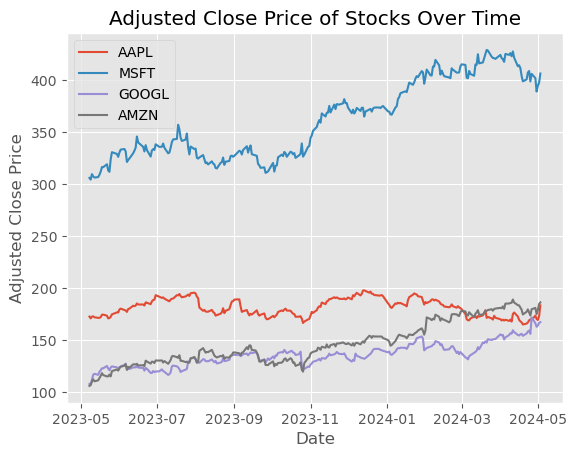

In [847]:
import matplotlib.pyplot as plt

# Create a plot to show closing price of each ticker
for ticker in stock_info['Ticker'].unique():
    subset = stock_info[stock_info['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Adj Close'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price of Stocks Over Time')
plt.legend()

# Show the plot
plt.show()

## Daily Simple Return

In [848]:
returns = pd.DataFrame()

for ticker in stock_info['Ticker'].unique():
    subset = stock_info[stock_info['Ticker'] == ticker]
    ticker_change = subset.set_index('Date')['Adj Close'].pct_change()  # Keep the date index

    returns[ticker] = ticker_change  # This ensures the Date remains as the index

returns.dropna(how='all', inplace=True)

# Check the resulting DataFrame
print(returns.head())

                AAPL      MSFT     GOOGL      AMZN
Date                                              
2023-05-09 -0.009971 -0.005346 -0.003897  0.007465
2023-05-10  0.010421  0.017296  0.040987  0.033483
2023-05-11  0.001095 -0.007044  0.043132  0.018060
2023-05-12 -0.005417 -0.003676  0.008064 -0.017115
2023-05-15 -0.002897  0.001586 -0.008510  0.008525


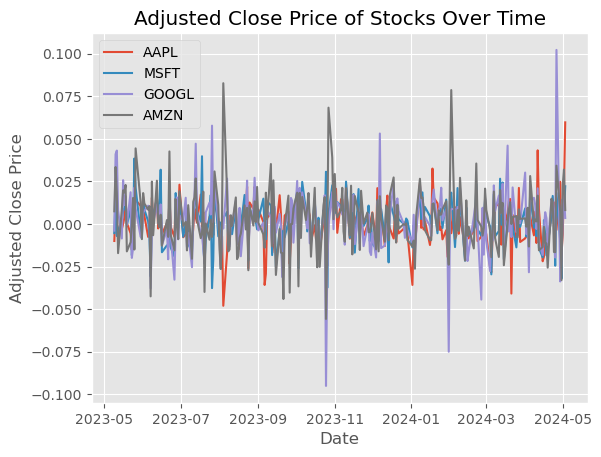

In [849]:
for ticker in returns.columns:
    plt.plot(returns.index, returns[ticker], label=ticker)

plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price of Stocks Over Time')
plt.legend()

plt.show()

## Creating Covariance Matrix

In [850]:
cov_matrix = returns.cov()
print(cov_matrix)

           AAPL      MSFT     GOOGL      AMZN
AAPL   0.000162  0.000082  0.000089  0.000082
MSFT   0.000082  0.000178  0.000113  0.000140
GOOGL  0.000089  0.000113  0.000333  0.000180
AMZN   0.000082  0.000140  0.000180  0.000334


### Mean Weights

In [851]:
mean_returns = returns.mean()
num_assets = len(returns.columns)

## Defining Metrics

Through mean, variance, and covariance we can formulate an optimization problem where you aim to minimize the portfolio's variance given expected returns or maximize the expected return for a given level of risk.\
**Formula:**
$\sigma^2_p = w^T \Sigma w$
### Efficient Frontier 
The set of optimal portfolios that offer the highest returns with a low level of risk or the lowest risk with the highest returns is known as the Efficient Frontier. 

In [852]:
 def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    # Weights must range from 0-1
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std_dev, returns

Mean returns helps in estimating the expected return of each asset and thus the return of the whole portfolio

## Optimizing Weights

Identifying the portfolio with less mean variance 

In [853]:
from scipy.optimize import minimize
def portfolio_variance(weights):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

def portfolio_sharpe(weights):
    return -((portfolio_performance(weights, mean_returns, cov_matrix)[1] - risk_free_rate) / portfolio_performance(weights, mean_returns, cov_matrix)[0])

In [854]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights must be 1
bounds = tuple((0,1) for asset in range(num_assets)) 
risk_free_rate = 0.01  #We would like a risk of 1%

In [855]:
# All stocks have the same weights at the start
initial_weights = np.array(num_assets * [1. / num_assets])

In [856]:
# Minimum variance
optimal_var_min = minimize(portfolio_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Maximize Sharpe Ratio
optimal_sharpe = minimize(portfolio_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

In [857]:
print('Optimal weights for minimum variance')
weights_min_var = optimal_var_min['x']
print(weights_min_var)
weighted_returns = np.dot(returns, weights_min_var.T)
returns['Weighted_Returns'] = weighted_returns 
returns.head()

Optimal weights for minimum variance
[0.50183208 0.36878335 0.08388962 0.04549495]


,AAPL,MSFT,GOOGL,AMZN,Weighted_Returns
Date,,,,,
2023-05-09,-0.009971,-0.005346,-0.003897,0.007465,-0.006963
2023-05-10,0.010421,0.017296,0.040987,0.033483,0.016570
2023-05-11,0.001095,-0.007044,0.043132,0.018060,0.002391
2023-05-12,-0.005417,-0.003676,0.008064,-0.017115,-0.004176
2023-05-15,-0.002897,0.001586,-0.008510,0.008525,-0.001195


## Create features

Using rolling weighted returns, the standard deviation of the weighted returns, and the previous returns. Along with the rolling closing prices in a window of 10 and 50 days. 

In [858]:
returns['MA_10'] = returns['Weighted_Returns'].rolling(window=10).mean()
returns['STD_10'] = returns['Weighted_Returns'].rolling(window=10).std()
returns['Previous_Returns'] = returns['Weighted_Returns'].shift(1)
returns.head()

,AAPL,MSFT,GOOGL,AMZN,Weighted_Returns,MA_10,STD_10,Previous_Returns
Date,,,,,,,,
2023-05-09,-0.009971,-0.005346,-0.003897,0.007465,-0.006963,NaN,NaN,NaN
2023-05-10,0.010421,0.017296,0.040987,0.033483,0.016570,NaN,NaN,-0.006963
2023-05-11,0.001095,-0.007044,0.043132,0.018060,0.002391,NaN,NaN,0.016570
2023-05-12,-0.005417,-0.003676,0.008064,-0.017115,-0.004176,NaN,NaN,0.002391
2023-05-15,-0.002897,0.001586,-0.008510,0.008525,-0.001195,NaN,NaN,-0.004176


In [859]:
returns['MA_10'] = returns['Weighted_Returns'].rolling(window=10).mean()
# Volatility
returns['STD_10'] = returns['Weighted_Returns'].rolling(window=10).std()
returns['Previous_Returns'] = returns['Weighted_Returns'].shift(1)
returns = returns.dropna(subset=['MA_10', 'STD_10'])
returns.head()

,AAPL,MSFT,GOOGL,AMZN,Weighted_Returns,MA_10,STD_10,Previous_Returns
Date,,,,,,,,
2023-05-22,-0.005481,0.008921,0.018654,-0.010667,0.001619,0.003501,0.007633,-0.000672
2023-05-23,-0.015155,-0.018432,-0.019912,-0.000174,-0.016081,0.002589,0.009369,0.001619
2023-05-24,0.001632,-0.004473,-0.013544,0.015306,-0.001270,0.000805,0.008012,-0.016081
2023-05-25,0.006692,0.038458,0.021340,-0.014989,0.018649,0.002431,0.009816,-0.001270
2023-05-26,0.014105,0.021386,0.009151,0.044435,0.017754,0.004624,0.010594,0.018649


In [860]:
stock_info['Date'] = pd.to_datetime(stock_info['Date'])

# Set 'Date' as the index for both DataFrames.
stock_info.set_index('Date', inplace=True)
stock_info.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker
Date,,,,,,,
2023-05-08,172.479996,173.850006,172.110001,173.500000,172.578827,55962800,AAPL
2023-05-09,173.050003,173.539993,171.600006,171.770004,170.858017,45326900,AAPL
2023-05-10,173.020004,174.029999,171.899994,173.559998,172.638519,53724500,AAPL
2023-05-11,173.850006,174.589996,172.169998,173.750000,172.827484,49514700,AAPL
2023-05-12,173.619995,174.059998,171.000000,172.570007,171.891205,45497800,AAPL


In [861]:
stock_info['MA_10_close'] = stock_info.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(window=10).mean())
stock_info['MA_50_close'] = stock_info.groupby('Ticker')['Adj Close'].transform(lambda x: x.rolling(window=50).mean())
stock_info = stock_info.dropna(subset=['MA_10_close', 'MA_50_close'])
stock_info.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker,MA_10_close,MA_50_close
Date,,,,,,,,,
2023-07-19,193.100006,198.229996,192.649994,195.100006,194.332581,80507300,AAPL,190.547519,181.653510
2023-07-20,195.089996,196.470001,192.500000,193.130005,192.370331,59581200,AAPL,190.679001,182.049340
2023-07-21,194.100006,194.970001,191.229996,191.940002,191.185013,71917800,AAPL,190.804507,182.455880
2023-07-24,193.410004,194.910004,192.250000,192.750000,191.991806,45377800,AAPL,191.216878,182.842946
2023-07-25,193.330002,194.440002,192.919998,193.619995,192.858398,37283200,AAPL,191.768698,183.243564


In [862]:
merged_df = returns.merge(stock_info[['MA_10_close', 'MA_50_close']], left_index=True, right_index=True, how='left')
merged_df.dropna(subset=['MA_10_close', 'MA_50_close'], inplace=True)
merged_df.head()

,AAPL,MSFT,GOOGL,AMZN,Weighted_Returns,MA_10,STD_10,Previous_Returns,MA_10_close,MA_50_close
Date,,,,,,,,,,
2023-07-19,0.007072,-0.012267,-0.013979,0.019047,-0.001281,0.003056,0.009103,0.013157,190.547519,181.653510
2023-07-19,0.007072,-0.012267,-0.013979,0.019047,-0.001281,0.003056,0.009103,0.013157,340.771600,328.333149
2023-07-19,0.007072,-0.012267,-0.013979,0.019047,-0.001281,0.003056,0.009103,0.013157,121.251000,121.076600
2023-07-19,0.007072,-0.012267,-0.013979,0.019047,-0.001281,0.003056,0.009103,0.013157,131.557999,123.477000
2023-07-20,-0.010097,-0.023122,-0.023191,-0.039894,-0.017354,0.001038,0.011164,-0.001281,190.679001,182.049340


## Splitting data

Past dates are used as the training set, while future dates (dates after training) are the test set.

In [863]:
merged_df = merged_df.sort_index()
split_point = int(len(merged_df) * 0.7)
X_train = merged_df.iloc[:split_point].drop(['Weighted_Returns'], axis=1)
y_train = merged_df.iloc[:split_point]['Weighted_Returns']
X_test = merged_df.iloc[split_point:].drop(['Weighted_Returns'], axis=1)
y_test = merged_df.iloc[split_point:]['Weighted_Returns']

In [864]:
print("Training data date range:")
print("Start date:", X_train.index.min())
print("End date:", X_train.index.max())

# Print the date range for the test data
print("Test data date range:")
print("Start date:", X_test.index.min())
print("End date:", X_test.index.max())

Training data date range:
Start date: 2023-07-19 00:00:00
End date: 2024-02-07 00:00:00
Test data date range:
Start date: 2024-02-07 00:00:00
End date: 2024-05-03 00:00:00


## Model Definition

In [865]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

param_grid = {
    'max_depth': [2, 3],
    'min_samples_split': [10,15,20,30],
    'max_features': [3, 5, 7],
    'n_estimators': [100, 200]
}

In [866]:
model_rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
grid_search_rf.fit(X_train, y_train)
best_params = grid_search_rf.best_params_
best_score = grid_search_rf.best_score_

best_params, best_score

Fitting 5 folds for each of 48 candidates, totalling 240 fits


({'max_depth': 3,
  'max_features': 5,
  'min_samples_split': 15,
  'n_estimators': 100},
 -0.0031890707812833805)

In [867]:
cross_val_rmse_tree = cross_val_score(grid_search_rf.best_estimator_, X_test, y_test, cv=5, scoring=make_scorer(mean_squared_error, squared=False))

print(f'RMSE of the stacking regressor on the test set: {cross_val_rmse_tree.mean()}')

RMSE of the stacking regressor on the test set: 0.005336115573623833


In [868]:
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
# Create the models for ensemble

model1_r = Pipeline([('model', SVR())])
model2_r = Pipeline([('model', DecisionTreeRegressor())])
model3_r = Pipeline([('model', KNeighborsRegressor())])

                 
## Create the ensemble
my_ensemble_r = VotingRegressor(estimators=[('svr', model1_r),('tree', model2_r),('knn', model3_r)])

params_r = {'svr__model__kernel': ['linear', 'rbf', 'poly'],
           'svr__model__C': [1, 10, 50, 100],
           'tree__model__max_depth': [2,3,4,5], 
           'knn__model__n_neighbors': [10,25,50,100]
           }

grid_r = GridSearchCV(my_ensemble_r, param_grid=params_r, cv=5, scoring = 'neg_root_mean_squared_error').fit(X_train, y_train)

cross_val_rmse = cross_val_score(grid_r.best_estimator_, X_train, y_train, cv=5, scoring=make_scorer(mean_squared_error, squared=False))


print(f'Best Ensemble: {cross_val_rmse.mean()}');

Best Ensemble: 0.007829335831054019


In [869]:
# Creating ensemble from the best Random Forest model
best_random_forest = grid_search_rf.best_estimator_

stacked_r = StackingRegressor(estimators=[('voting', grid_r.best_estimator_)], final_estimator=DecisionTreeRegressor(max_depth=3))
stacked_ensemble = stacked_r

ensemble_voting = VotingRegressor(estimators=[
    ('random_forest', best_random_forest),
    ('stacked', stacked_ensemble)
])
ensemble_voting.fit(X_train, y_train)

VotingRegressor(estimators=[('random_forest',
                             RandomForestRegressor(max_depth=3, max_features=5,
                                                   min_samples_split=15,
                                                   random_state=42)),
                            ('stacked',
                             StackingRegressor(estimators=[('voting',
                                                            VotingRegressor(estimators=[('svr',
                                                                                         Pipeline(steps=[('model',
                                                                                                          SVR(C=10,
                                                                                                              kernel='poly'))])),
                                                                                        ('tree',
                                                                                         Pipeline(steps=[('model',
                                                                                                          DecisionTreeRegressor(max_depth=5))])),
                                                                                        ('knn',
                                                                                         Pipeline(steps=[('model',
                                                                                                          KNeighborsRegressor(n_neighbors=50))]))]))],
                                               final_estimator=DecisionTreeRegressor(max_depth=3)))])

In [870]:
ensemble_predictions = ensemble_voting.predict(X_test)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_predictions))
print(f'RMSE of the VotingRegressor ensemble on the test set: {ensemble_rmse}')

RMSE of the VotingRegressor ensemble on the test set: 0.004786802111230061


In [871]:
# very simple model with better RMSE
from sklearn.ensemble import RandomForestRegressor

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediction
predicted_returns = model.predict(X_test)
from sklearn.metrics import mean_squared_error

std_dev = np.std(y_train)
print("Standard Deviation of Returns:", std_dev)
mse = mean_squared_error(y_test, predicted_returns)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Standard Deviation of Returns: 0.010878093953211184
Mean Squared Error: 1.4205683618682513e-05
Root Mean Squared Error (RMSE): 0.003769042798733189
